<a href="https://colab.research.google.com/github/arjunshenoymec/bitpredict/blob/main/BitPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting values of cyrpto-currency coins using LSTM and Neural Networks

In this notebook we describe some ways in which price data associated with various cryptocurrencies can be analysed and prepared for forecasting. We also explore the use of the Long Short-Term Memory (LSTM) for timeseries forecasting. 

The First step is to import the necessary libraries and create a basic DataFrame from the raw data. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np 
import os

!pip install cpi
import cpi

     |████████████████████████████████| 29.0 MB 1.3 MB/s 


Using the `wget` command so that the data is available locally in the notebook. 

In [2]:
# obtaining the data from the repo 
# Data originally obtained from https://www.kaggle.com/philmohun/cryptocurrency-financial-data
!wget https://raw.githubusercontent.com/arjunshenoymec/bitpredict/main/datasets/consolidated_coin_data.csv

--2022-03-26 12:56:08--  https://raw.githubusercontent.com/arjunshenoymec/bitpredict/main/datasets/consolidated_coin_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2274439 (2.2M) [text/plain]
Saving to: ‘consolidated_coin_data.csv’

consolidated_coin_d 100%[===================>]   2.17M  --.-KB/s    in 0.06s   

2022-03-26 12:56:08 (33.9 MB/s) - ‘consolidated_coin_data.csv’ saved [2274439/2274439]



Creating the DataFrame with Date as the index. 

In [3]:
df = pd.read_csv("consolidated_coin_data.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"])

In [4]:
df

,Currency,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2019-12-04,tezos,1.29,1.32,1.25,1.25,"46,048,752","824,588,509"
2019-12-03,tezos,1.24,1.32,1.21,1.29,"41,462,224","853,213,342"
2019-12-02,tezos,1.25,1.26,1.20,1.24,"27,574,097","817,872,179"
2019-12-01,tezos,1.33,1.34,1.25,1.25,"24,127,567","828,296,390"
2019-11-30,tezos,1.31,1.37,1.31,1.33,"28,706,667","879,181,680"
...,...,...,...,...,...,...,...
2013-05-02,bitcoin-sv,3.78,4.04,3.01,3.37,0,"58,287,979"
2013-05-01,bitcoin-sv,4.29,4.36,3.52,3.80,0,"65,604,596"
2013-04-30,bitcoin-sv,4.40,4.57,4.17,4.30,0,"74,020,918"


## Verifying the data is set to the appropriate type

So far we've created the dataframe to analyse the data, pass it to various models for training and prediction. The first step we need to do is to verify if the columns in the data frame are of the appropriate type. In this notebook we will be focusing primarily on the `Close` value of the coins.  Let's check the datatype for Close. 

In [5]:
print(df['Close'][0])
print(type(df['Close'][0]))

1.25
<class 'str'>


We see that it is a string and that won't do. Most of the algorithms that we are going to use for analysing the data expect the data to be floating point numbers. So the first step we've got to do is to convert the data in the `Close` column to `float`. 

In [6]:
# Converting the close values to floating point numbers, they are currently present as stirngs
df['Close'] = df['Close'].apply(lambda x: float(x.replace(",",""))) 

In [7]:
print(df['Close'][0])
print(type(df['Close'][0]))

1.25
<class 'numpy.float64'>


In the dataframe we can see various currencies mentioned. It would be better to separate the data pertaining to each of them so that we can focus on one particular case and then apply what we have learned from it to the others (in terms of steps and take aways. One model (like LSTM) might be the best in the case of one coin but might not be the best for another coin). 

In [8]:
YEARS = sorted(list(df.index.year.unique()))
CURRENCIES = list(df.Currency.unique())
CURRENCIES

['tezos',
 'binance-coin',
 'eos',
 'bitcoin',
 'tether',
 'xrp',
 'bitcoin-cash',
 'stellar',
 'litecoin',
 'ethereum',
 'cardano',
 'bitcoin-sv']

We are only going to focus on the `Close` price of a coin, so we do not need the other columns for our experiments. 

In [9]:
# logic to getting the data pertaining to a particular currency 
def filter_by_currency(df, currency):
  currency_df = df[df['Currency']==currency]
  currency_df = pd.DataFrame(currency_df['Close']).rename(columns={"Close": "price"})
  currency_df['year'] = currency_df.index.year
  return currency_df

In [10]:
tezos_data = filter_by_currency(df, 'tezos')
tezos_data

,price,year
Date,,
2019-12-04,1.25,2019
2019-12-03,1.29,2019
2019-12-02,1.24,2019
2019-12-01,1.25,2019
2019-11-30,1.33,2019
...,...,...
2013-05-02,3.37,2013
2013-05-01,3.80,2013
2013-04-30,4.30,2013


In [11]:
def plot_currency_data(currency_frame, currency_name):
  plt.figure(figsize=(10, 10))
  plt.plot(currency_frame.index.to_numpy(), currency_frame.price.to_numpy(), label=currency_name)
  plt.xlabel('Date')
  plt.ylabel('price')
  plt.legend(fontsize=14)
  plt.show()

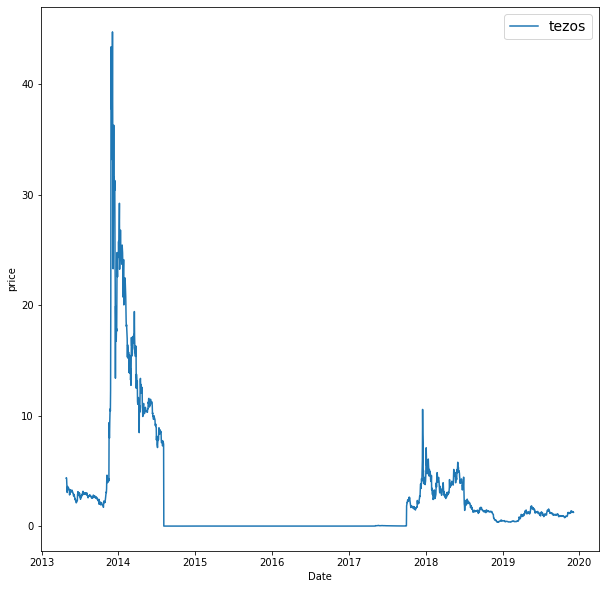

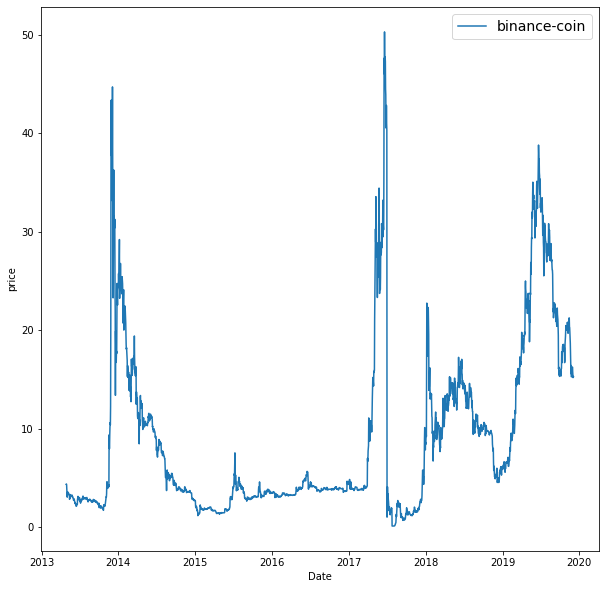

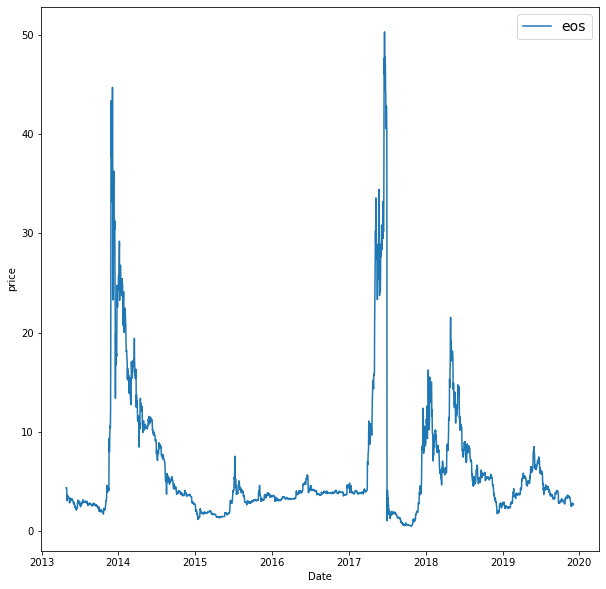

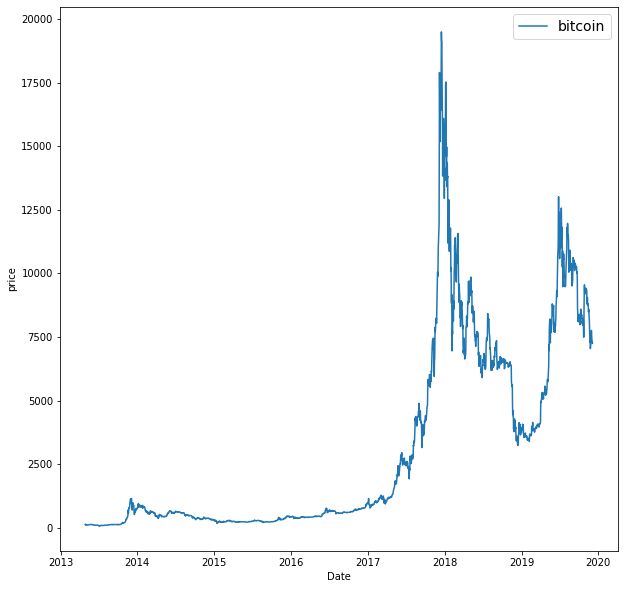

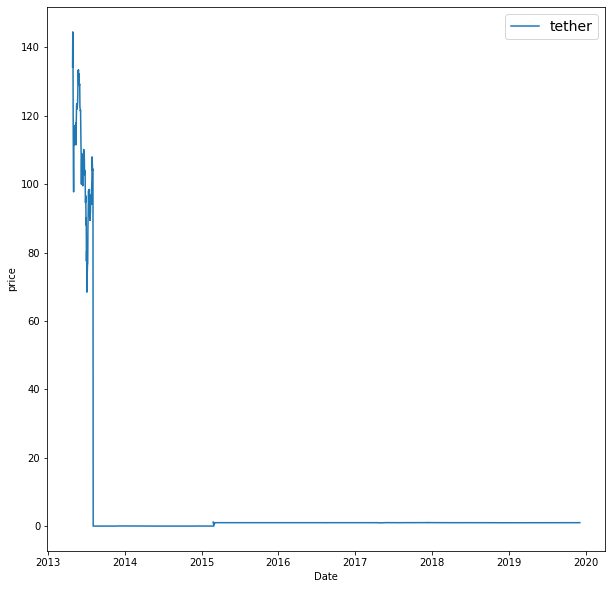

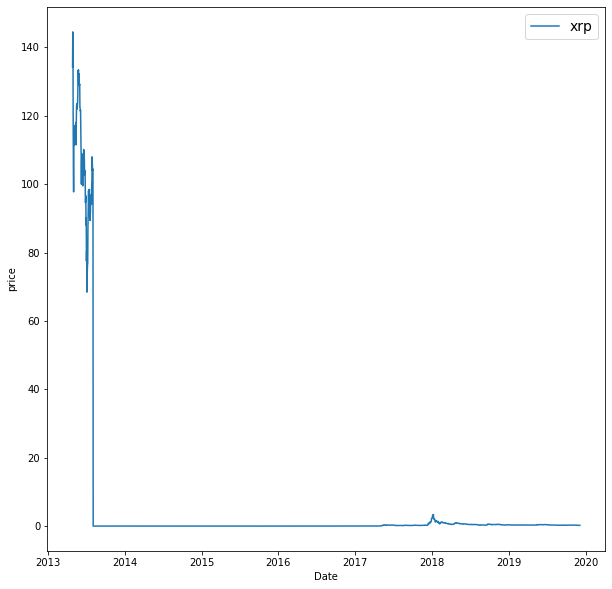

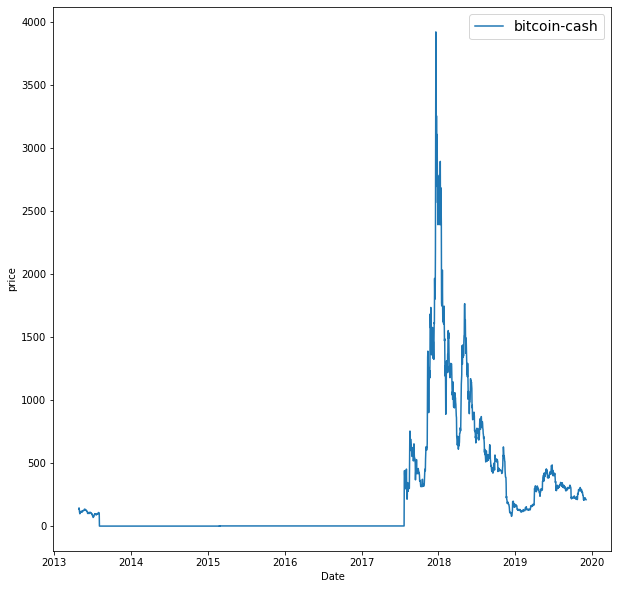

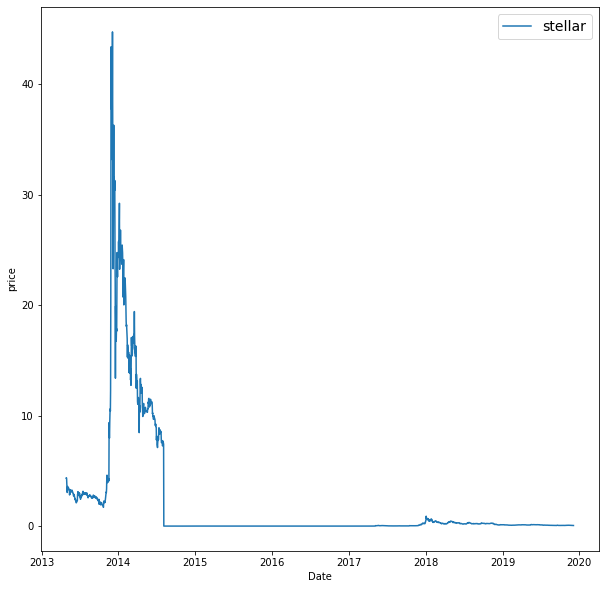

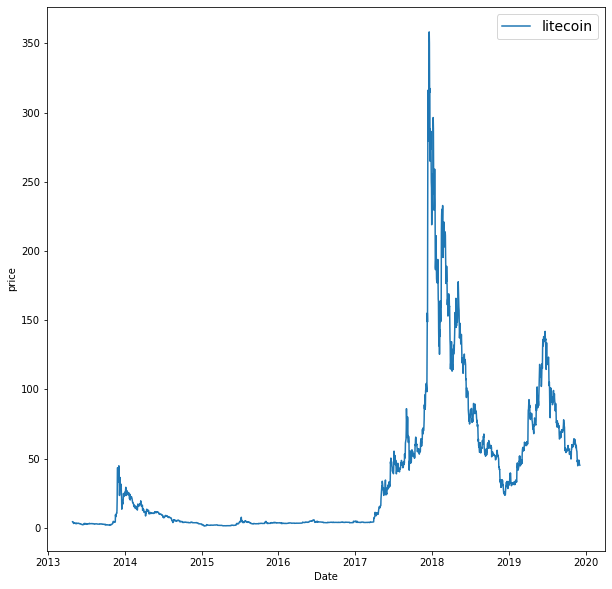

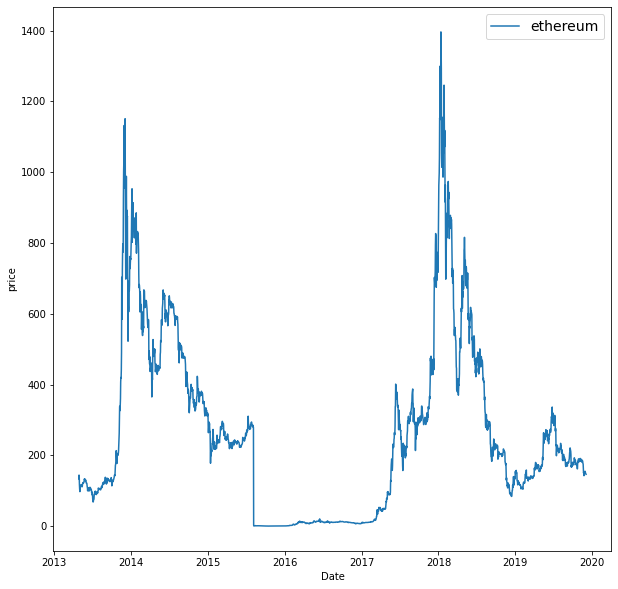

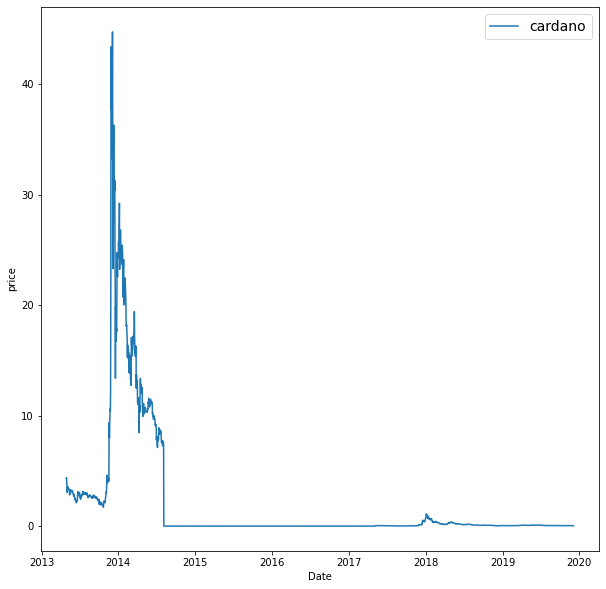

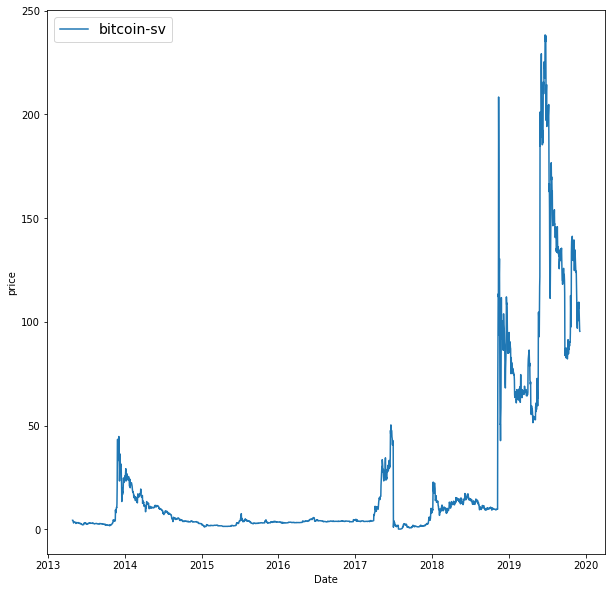

In [12]:
currency_df_map = {}
for currency in CURRENCIES:
  currency_df_map[currency] = filter_by_currency(df, currency)

for currency in CURRENCIES:
  plot_currency_data(currency_df_map[currency], currency)

## Inflation adjustment

Since this is financial data, we need to adjust the data according to inflation so that the forecasts make sense. We plan to do this using the cpi library (Note: this library only works with US$ data). (Ref: https://towardsdatascience.com/the-easiest-way-to-adjust-your-data-for-inflation-in-python-365490c03969). 

This adjustment has to do with the fact that as the years go by the basic "value" (value can be considered in terms of purchasing power) of currency changes eg: a \$1 back in 1920 is equivalent to about $14.19 today ([ref](https://www.in2013dollars.com/us/inflation/1920?amount=1)). 

In [13]:
tezos_data['inflated_price'] = tezos_data.apply(lambda x: cpi.inflate(x['price'],int(x['year'])), axis=1)
tezos_data

,price,year,inflated_price
Date,,,
2019-12-04,1.25,2019,1.324871
2019-12-03,1.29,2019,1.367267
2019-12-02,1.24,2019,1.314272
2019-12-01,1.25,2019,1.324871
2019-11-30,1.33,2019,1.409663
...,...,...,...
2013-05-02,3.37,2013,3.919903
2013-05-01,3.80,2013,4.420069
2013-04-30,4.30,2013,5.001657


In [14]:
def plot_currency_comparison(currency_frame, currency_name):
  plt.figure(figsize=(10, 10))
  plt.plot(currency_frame.index.to_numpy(), currency_frame.price.to_numpy(), label='normal')
  plt.plot(currency_frame.index.to_numpy(), currency_frame.inflated_price.to_numpy(), label='inflated')
  plt.xlabel('Date')
  plt.ylabel('price')
  plt.title(currency_name)
  plt.legend(fontsize=14)
  plt.show()


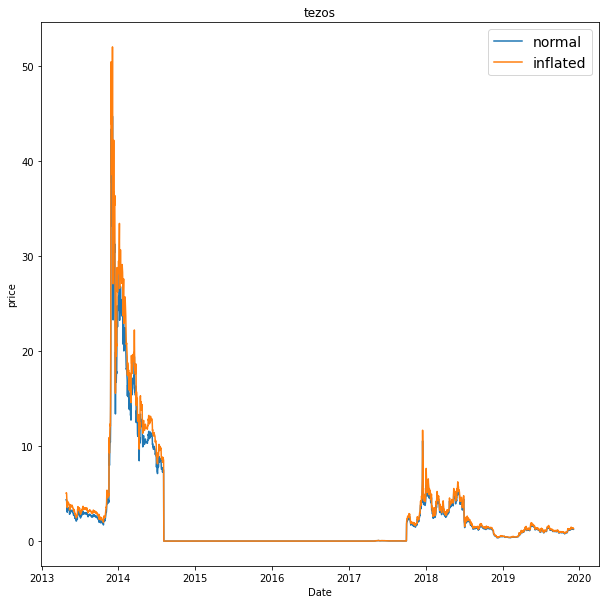

In [15]:
plot_currency_comparison(tezos_data, 'tezos')

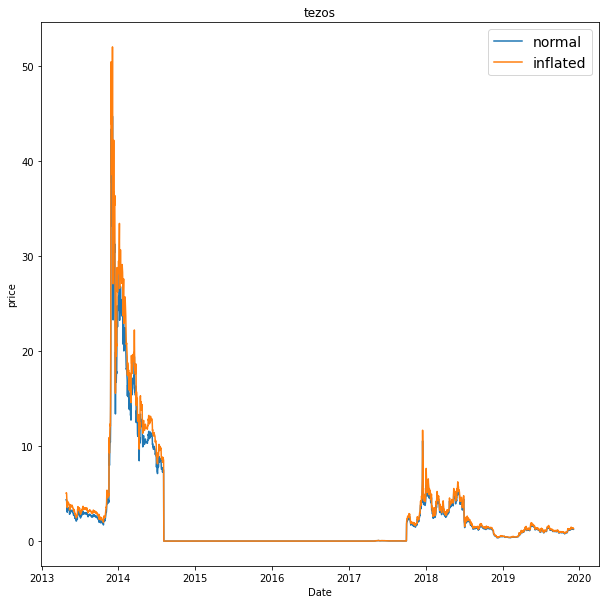

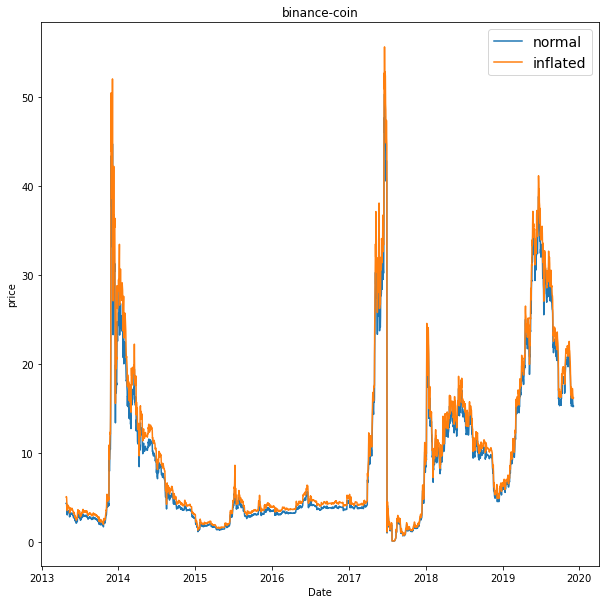

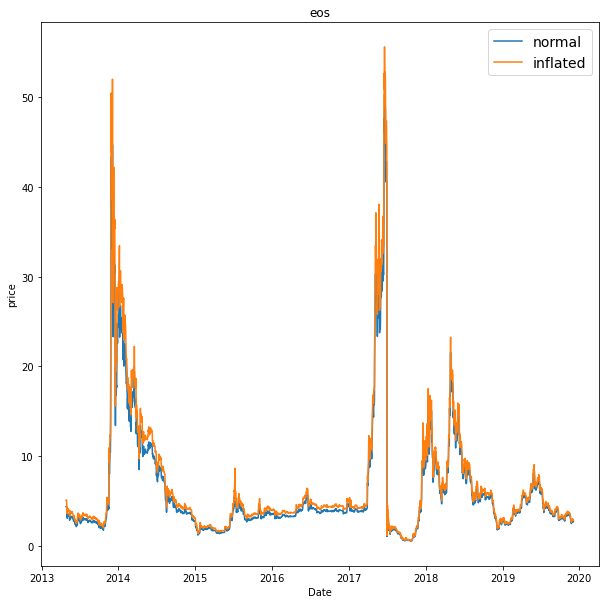

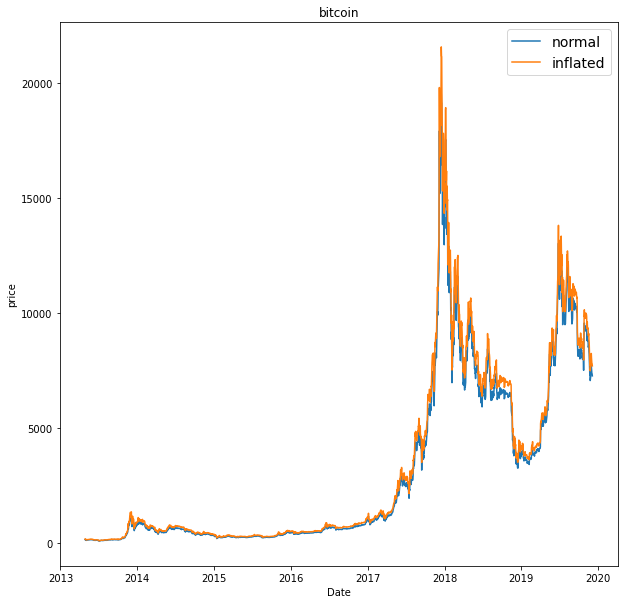

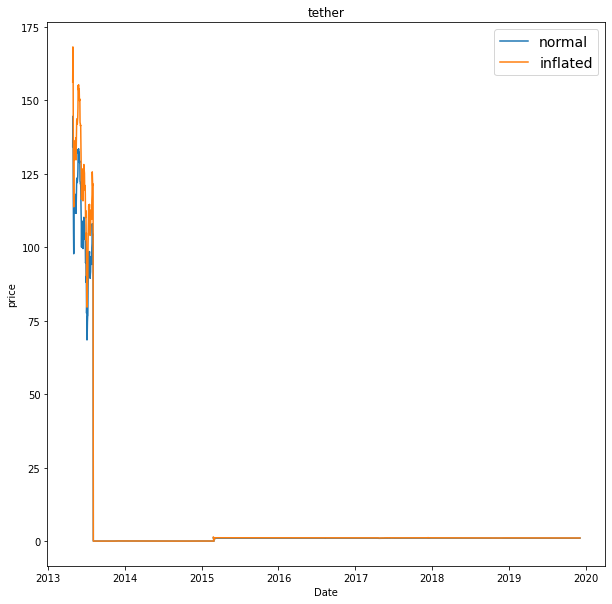

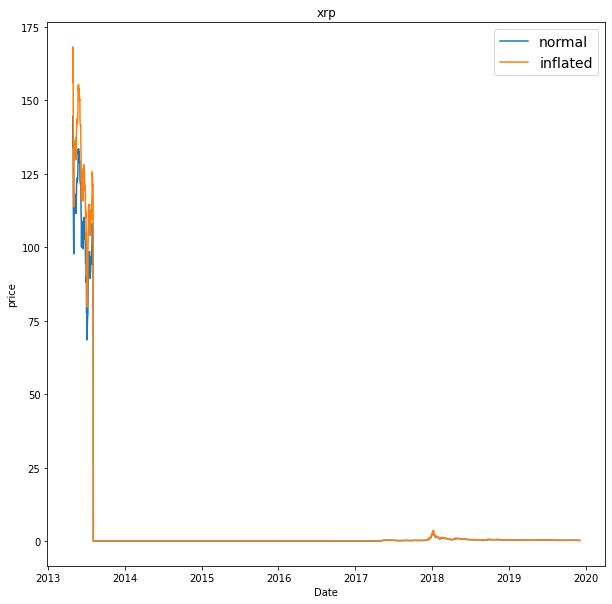

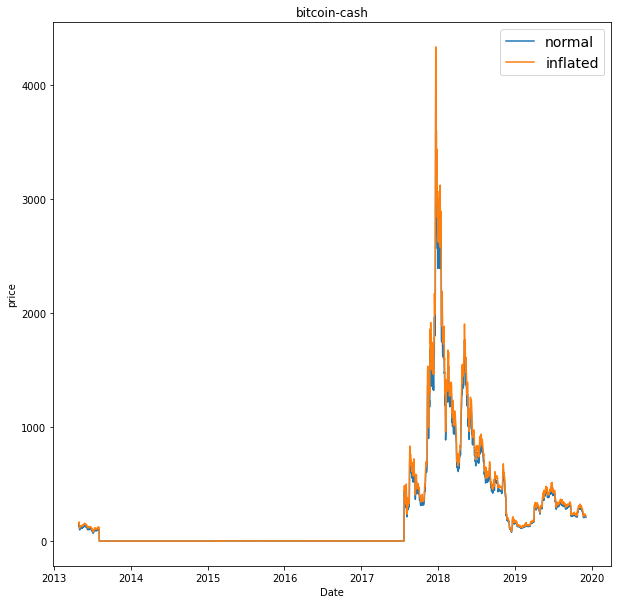

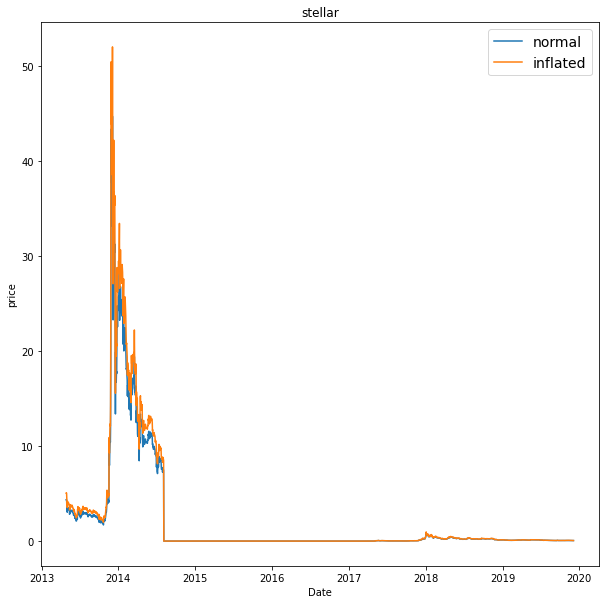

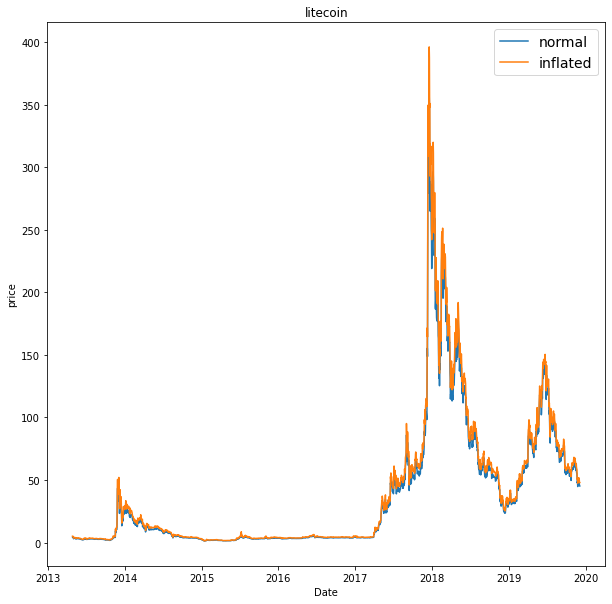

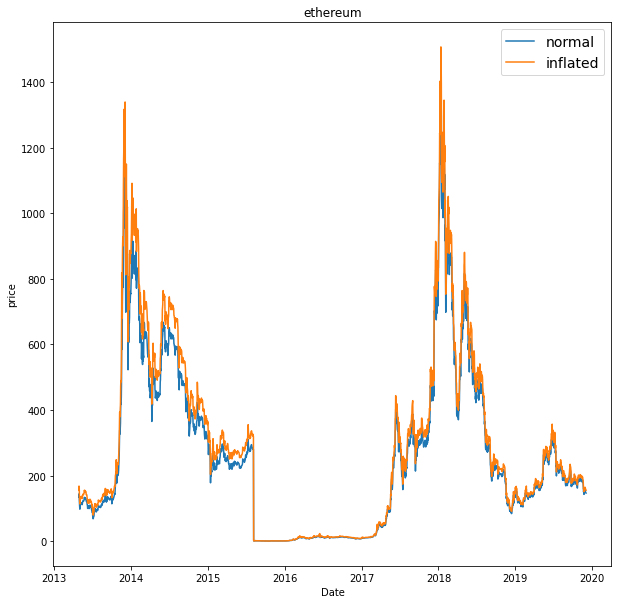

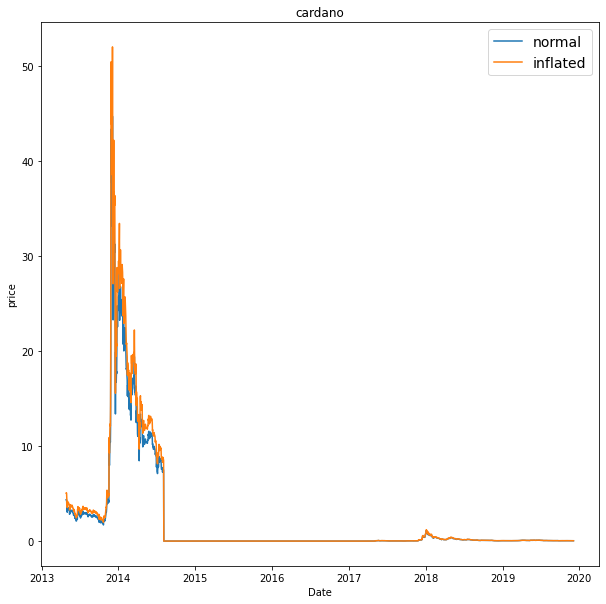

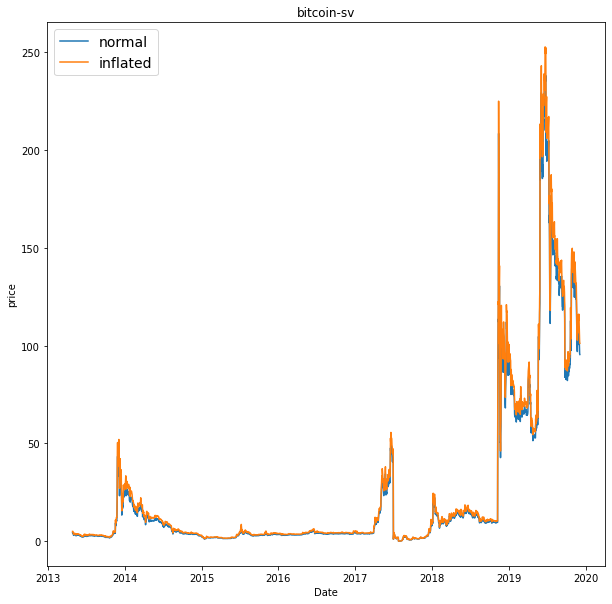

In [16]:
for currency in CURRENCIES:
  currency_df_map[currency]['inflated_price'] = currency_df_map[currency].apply(lambda x: cpi.inflate(x['price'],int(x['year'])), axis=1)


for currency in CURRENCIES: 
  plot_currency_comparison(currency_df_map[currency], currency)

## Data preparation 

In this section we describe various steps undertaken to prepare the data such that it is in a format suitable for the models. 

Going forward we will focus primarly on bitcoin. The functions in this section will be made generic so they can be used for the remaining currencies as well. 

In [17]:
# Just getting the price data
data = currency_df_map['bitcoin']
prices = np.flip(data.inflated_price.to_numpy())
prices

array([ 156.1098559 ,  168.12546436,  161.68146911, ..., 7760.55273394,
       7758.60252409, 7686.40236371])

One of the basic approaches to time-series forecasting is to reduce it to a supervised learning problem. Basically have two sets of variables such that when you pass one of them (the inputs) you get the other set (the outputs). So essentially forecasting becomes a linear regression problem (We make use of this interpretation down below). 

This splitting of the timeseries data into sets of inputs and outputs is known as `windowing` (Ref: https://machinelearningmastery.com/time-series-forecasting-supervised-learning/). 

In the code that follows below:

`window_size` Refers to the size of the input set (the number of past inputs to be passed to the model). 

`Horizon` Refers to the size of the output set (number of future values predicted). 

In [18]:
"""
Creates labels for windowed dataset.
E.g. if horizon=1 (default)
Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
"""
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

"""
Function to turn a 1D array into a 2D array of sequential windows of window_size.
"""
def make_windows(x, window_size=7, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [19]:
WINDOW_SIZE = 7
HORIZON = 1
data_windows, data_labels = make_windows(prices, WINDOW_SIZE, HORIZON)

In [20]:
print(data_windows.shape)
print(data_labels.shape)

(2405, 7)
(2405, 1)


Now that we've split the timeseries into windows and horizons (inputs and labels in general ML vernacular) it's time to split this set of data into training, validation and testing sets. 

In [21]:
"""
Function to split matching pairs of windows and labels into train and test splits.
"""
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [22]:
# Running the make_train_test_split function twice to create training, testing and validation sets.
train_validation_windows, test_windows, train_validation_labels, test_labels = make_train_test_splits(data_windows, data_labels)
train_windows, validation_windows, train_labels, validation_labels = make_train_test_splits(train_validation_windows, train_validation_labels, test_split=0.1)


In [23]:
train_windows.shape
tf.expand_dims(train_windows, axis=1).shape

TensorShape([1731, 1, 7])

## Forecasting using LSTM.

Now we get to the part where we experiment with various models to determine which model perform the best (this also includes exploring some of the hyperparameters associated with the models). 

A single experiment consists of the following steps: 
* Setting up the model with appropriate hyperparameters. 
* Training the model with the `train_windows` and `train_labels`. (This stage also involves validation). 
* Making the predictions for `test_windows` and evaluating the performance metrics by comparing the predictions with `test_labels`. 

We typically also plot the actual and predicted data to see if we can "eye-ball" the differences between various models. 

The first model we will consider here is an LSTM (we use TensorFlow here). The LSTM expects the data in a certain [shape](https://tensorflow.rstudio.com/guide/tensorflow/tensors/#shape). It expects the data passed to be of the shape `[batch_size, timesteps, features]`. 

* batch_size: The number of separate timeseries passed to the model.
* timesteps: The number of timesteps in an indivdiual timeseries input.
* features: The number of independent features present in an individual timestep. 

As mentioned above, there are various models and approaches we can take when trying to predict future values for a time series. The way we have prepared the data right now (using windowing) considers forcasting as a linear regression problem so here we will pass `window_size` number of independent features at a time. In otherwords, for the experiments in this section we set `timesteps=1` and `features=window_size`. 

We later revisit the LSTM model to attempt the opposite interpretation in another section. 

Below we perform one experiment with an LSTM based model. The values for parameters such as lstm dimmenstionality, batch_size, number of epochs etc were chosen arbitararily. We will experiment with some of them in the following sections as well. 

In [24]:
tf.random.set_seed(42)

# Creating a model
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model = tf.keras.Model(inputs=inputs, outputs=output, name="lstm_1")
model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

# Training the model 
model.fit(train_windows, train_labels, epochs=100, batch_size=64, verbose=0,  validation_data=(validation_windows, validation_labels))


In [25]:
"""
Uses model to make predictions on input_data.

Parameters
----------
model: trained model 
input_data: windowed input data (same kind of data model was trained on)

Returns model predictions on input_data.
"""
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [26]:
# Making the predictions
predictions = make_preds(model, test_windows)

In [27]:
'''
Function to plot two timeseries
'''
def plot_comparison(timeline, series_a, series_b, series_a_name='', series_b_name=''):
  plt.figure(figsize=(15, 10))
  plt.plot(timeline, series_a, label=series_a_name)
  plt.plot(timeline, series_b, label=series_b_name)
  plt.xlabel('Date')
  plt.ylabel('price')
  plt.legend(fontsize=14)
  plt.show()

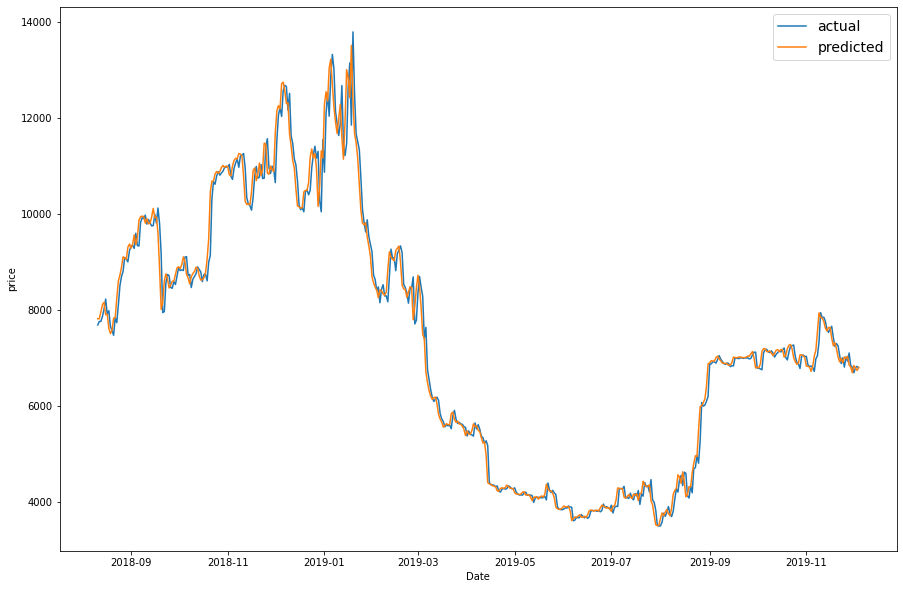

In [28]:
# Plotting the predictions along with the actual test data
timeline = data.index[:len(predictions)].to_numpy()
test_label_flat = tf.squeeze(test_labels)

plot_comparison(timeline, test_label_flat, predictions, 'actual', 'predicted')

From the plot we can see that even though the attribute values were chosen at random, the predictions seem to follow the actual values pretty closely. Now we move on to the next step of evaluating the performance of the model in a quantitative manner. 

In [29]:
# To quantify how good or how bad the performance of the model is. 
# Ref: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb
def evaluate_performance(actual, predicted):
  # Make sure float32 (for metric calculations)
  actual = tf.cast(actual, dtype=tf.float32)
  predicted = tf.cast(predicted, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(actual, predicted)
  mse = tf.keras.metrics.mean_squared_error(actual, predicted) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(actual, predicted)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [30]:
lstm_128_perf = evaluate_performance(tf.squeeze(test_labels), predictions)
lstm_128_perf

{'mae': 187.3227, 'mape': 2.4016788, 'mse': 99032.5, 'rmse': 314.6943}

### Exploring the impact of number of LSTM units has on the predictions

Here we are going to use the same model, also use the same data (the same split of training and testing datasets, same value for `window_size`, `horizon`, `batch_size` etc). We will only vary the number of units of the LSTM cell (in otherwords the dimensionality of the data coming out of the LSTM) to see if that has an impact on the predictions. 

In [31]:
# Creating a function to represent one single experiment iteration
# with a given unit size. 
def experiment_lstm_units(units):
  # Creating the model
  inputs = layers.Input(shape=(WINDOW_SIZE))
  x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
  x = layers.LSTM(units, activation="relu")(x)
  output = layers.Dense(HORIZON)(x)
  model = tf.keras.Model(inputs=inputs, outputs=output, name=f"lstm_{units}")
  model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
  # training the model
  model.fit(train_windows, train_labels, epochs=100, batch_size=128,  verbose=0, 
            validation_data=(validation_windows, validation_labels))
  # Predictions
  predictions = make_preds(model, test_windows)
  return predictions, evaluate_performance(tf.squeeze(test_labels), predictions)

In [32]:
lstm_10 = experiment_lstm_units(10)
lstm_64 = experiment_lstm_units(64)
lstm_256 = experiment_lstm_units(256)
lstm_512 = experiment_lstm_units(512)

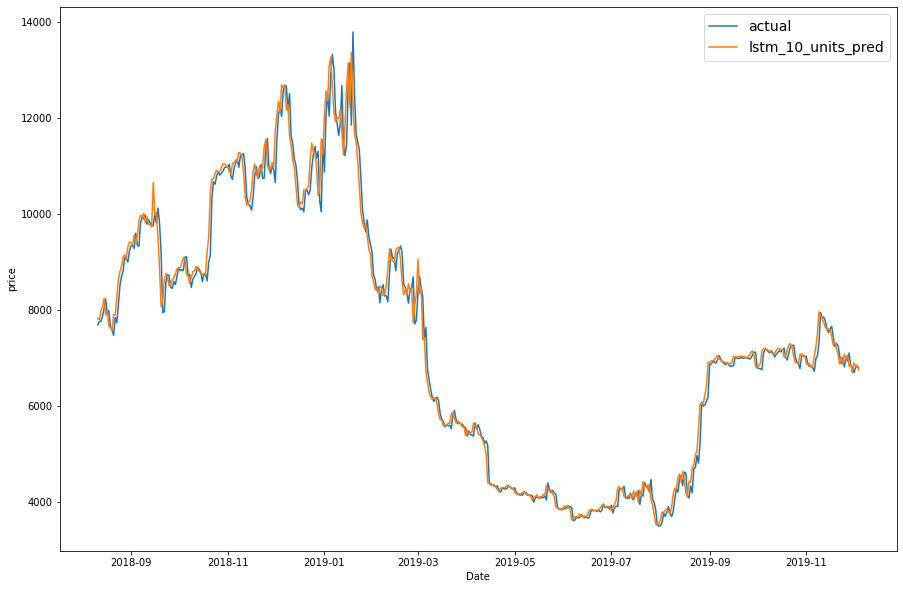

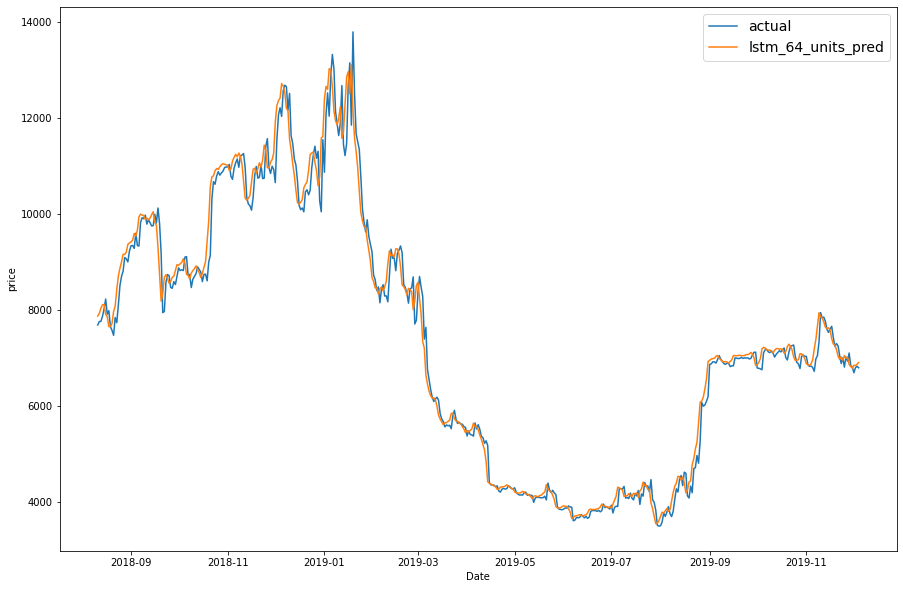

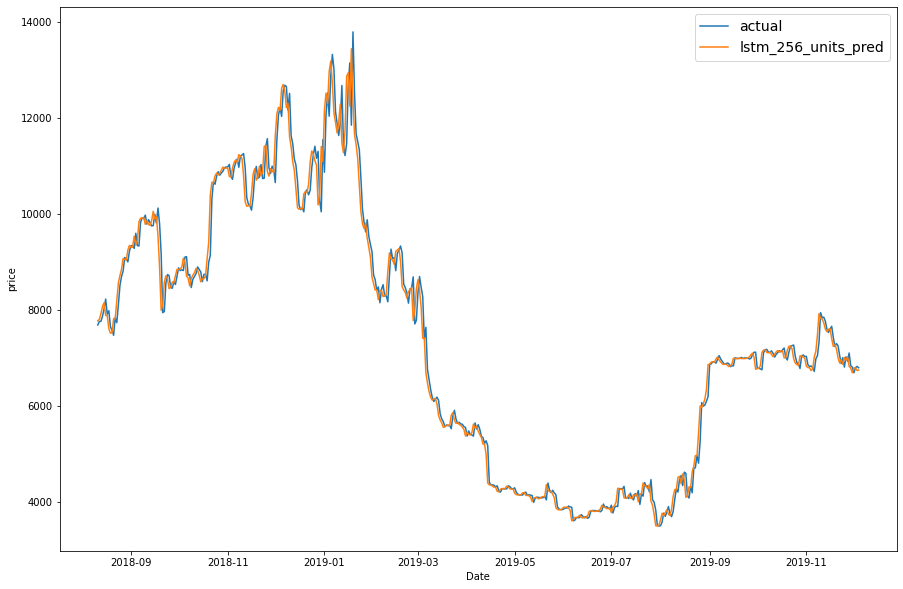

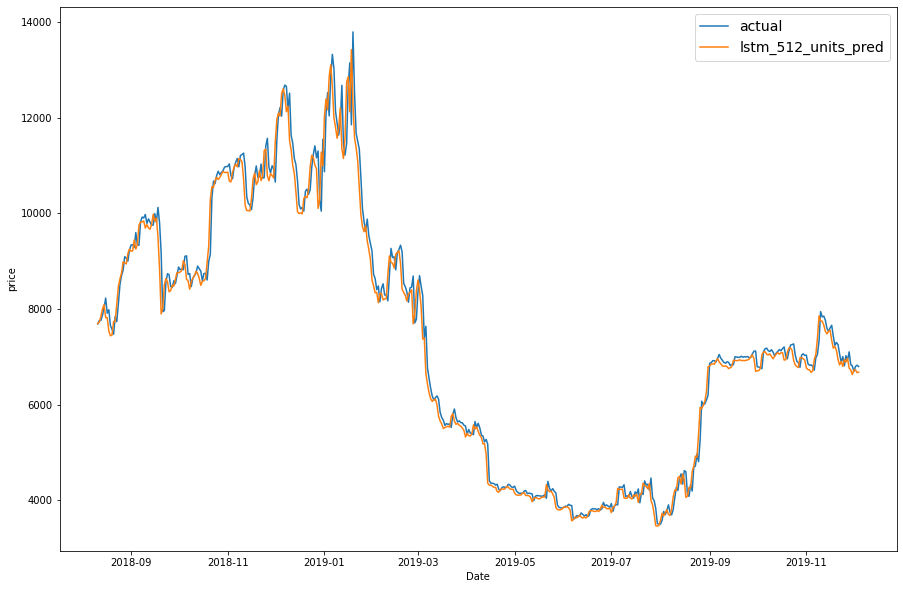

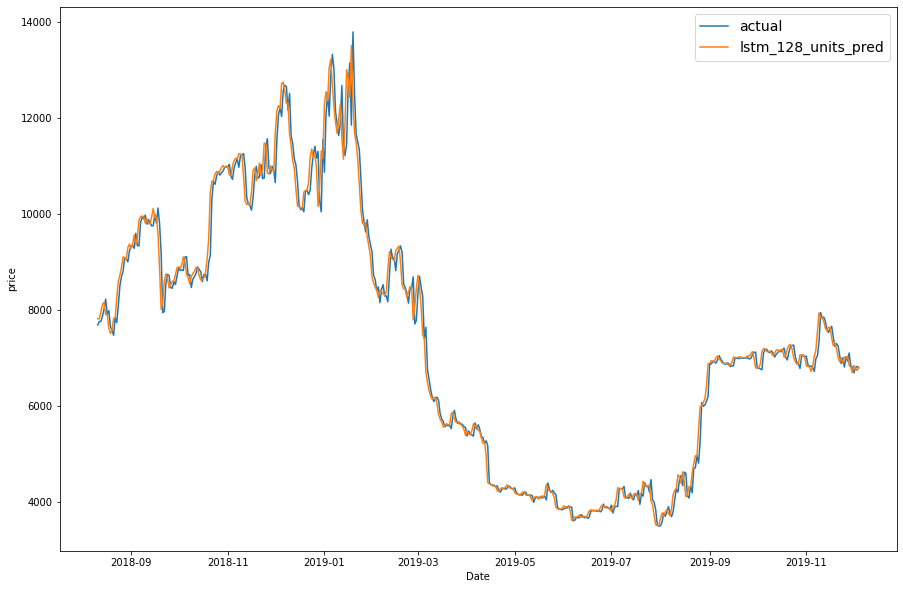

In [33]:
plot_comparison(timeline, test_label_flat, lstm_10[0], 'actual', 'lstm_10_units_pred')
plot_comparison(timeline, test_label_flat, lstm_64[0], 'actual', 'lstm_64_units_pred')
plot_comparison(timeline, test_label_flat, lstm_256[0], 'actual', 'lstm_256_units_pred')
plot_comparison(timeline, test_label_flat, lstm_512[0], 'actual', 'lstm_512_units_pred')
plot_comparison(timeline, test_label_flat, predictions, 'actual', 'lstm_128_units_pred')

We see that setting dimensionality to 128, 256 units come closest to the actual data (in this lot). 

In [34]:
performance_dict = {'lstm_10': lstm_10[1], 'lstm_128': lstm_128_perf, 'lstm_256': lstm_256[1], 'lstm_512': lstm_512[1], 'lstm_64': lstm_64[1]}

In [35]:
performance_df = pd.DataFrame.from_dict(performance_dict)
performance_df

,lstm_10,lstm_128,lstm_256,lstm_512,lstm_64
mae,192.410645,187.322693,183.660233,199.800034,217.507202
mse,100545.562500,99032.500000,95899.945312,100204.390625,117593.765625
rmse,317.089203,314.694305,309.677155,316.550781,342.919464
mape,2.487026,2.401679,2.352984,2.587361,2.832071


We've come to the same conclusion as before from the Graph. The LSTM with 256 units came the closest to the actual data (least error parameters). 

### Variation in batch_size

Here we will continue to use the plain LSTM (output dimmensionality set to `256` from the previous experiment) and vary the size of the batch passed to the model during training to see if that has an impact on the performance. 

In [36]:
def experiment_lstm_batch_size(batch_size):
  # Creating the model
  inputs = layers.Input(shape=(WINDOW_SIZE))
  x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
  x = layers.LSTM(256, activation="relu")(x)
  output = layers.Dense(HORIZON)(x)
  model = tf.keras.Model(inputs=inputs, outputs=output, name=f"lstm_batch_size_{batch_size}")
  model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
  # training the model
  model.fit(train_windows, train_labels, epochs=100, batch_size=batch_size,  verbose=0, 
            validation_data=(validation_windows, validation_labels))
  # Predictions
  predictions = make_preds(model, test_windows)
  return predictions, evaluate_performance(tf.squeeze(test_labels), predictions)

In [37]:
lstm_256_64 = experiment_lstm_batch_size(64)
lstm_256_32 = experiment_lstm_batch_size(32)
lstm_256_256 = experiment_lstm_batch_size(256)

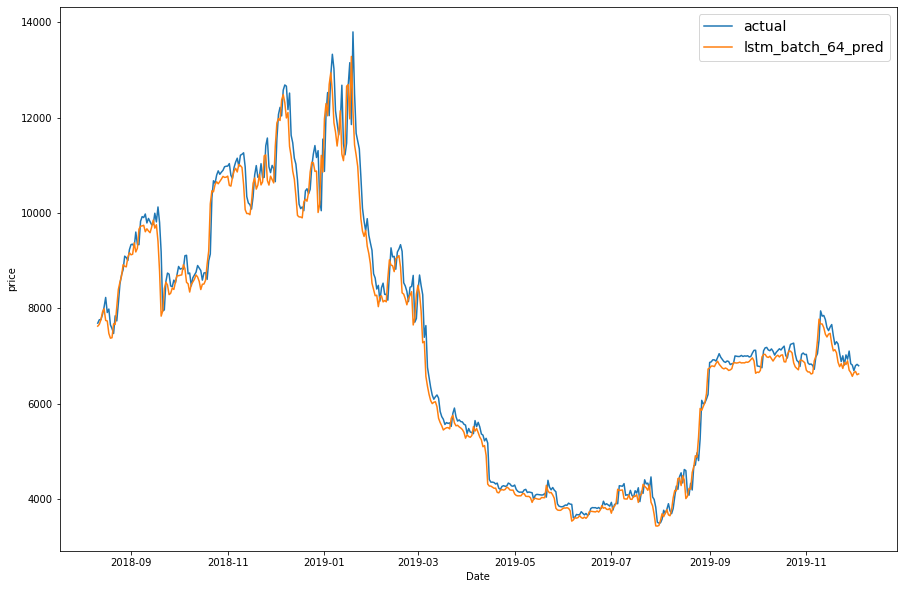

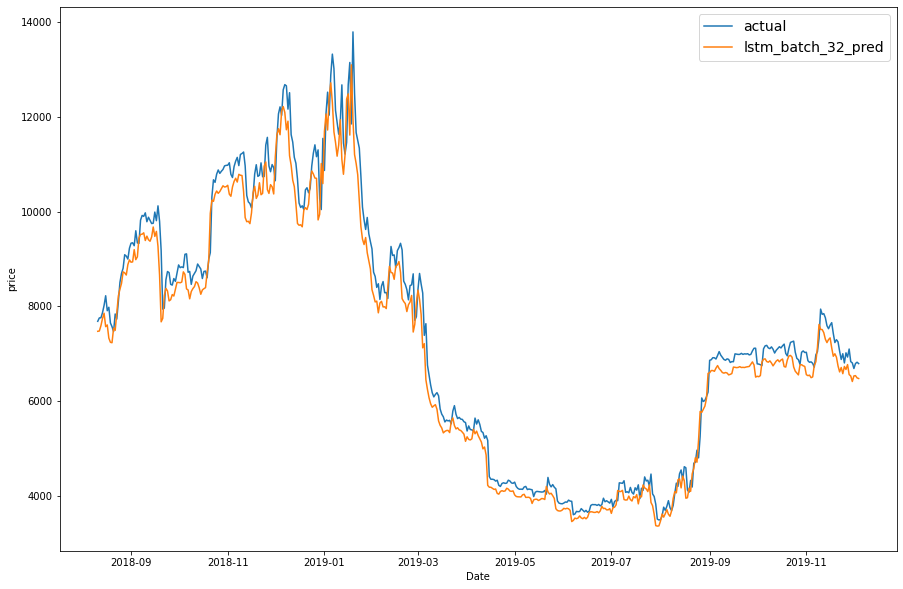

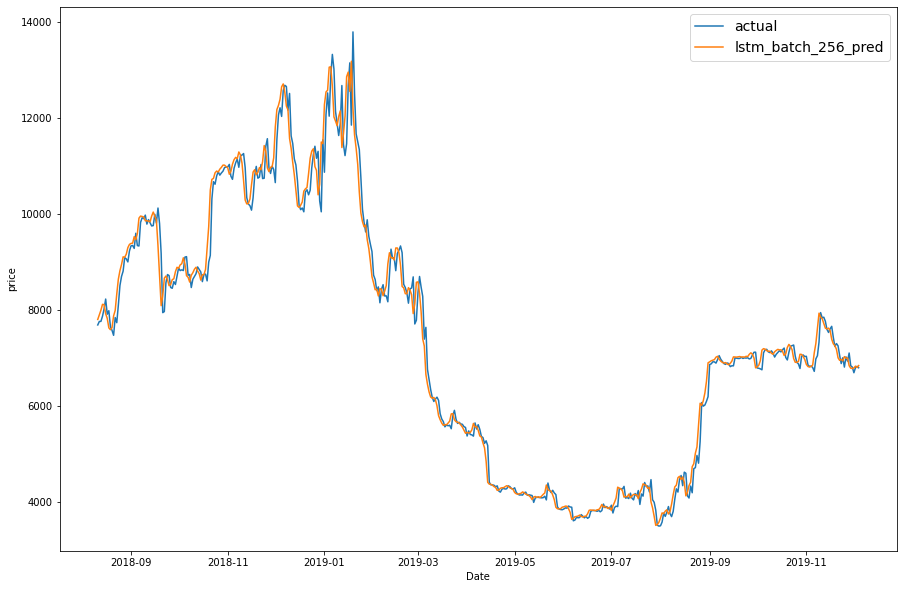

In [38]:
plot_comparison(timeline, test_label_flat, lstm_256_64[0], 'actual', 'lstm_batch_64_pred')
plot_comparison(timeline, test_label_flat, lstm_256_32[0], 'actual', 'lstm_batch_32_pred')
plot_comparison(timeline, test_label_flat, lstm_256_256[0], 'actual', 'lstm_batch_256_pred')

In [39]:
performance_dict['lstm_256_32'] = lstm_256_32[1]
performance_dict['lstm_256_64'] = lstm_256_64[1]
performance_dict['lstm_256_256'] = lstm_256_256[1]

performance_df = pd.DataFrame.from_dict(performance_dict)
performance_df

,lstm_10,lstm_128,lstm_256,lstm_512,lstm_64,lstm_256_32,lstm_256_64,lstm_256_256
mae,192.410645,187.322693,183.660233,199.800034,217.507202,336.708832,235.304321,202.381866
mse,100545.562500,99032.500000,95899.945312,100204.390625,117593.765625,185524.328125,117925.750000,109109.015625
rmse,317.089203,314.694305,309.677155,316.550781,342.919464,430.725342,343.403198,330.316528
mape,2.487026,2.401679,2.352984,2.587361,2.832071,4.497337,3.088403,2.617599


we see that default of 128 batch size is the ideal configuration in this setup. 

### Experimenting with window_size 

Here we explore how much of an impact `window_size` has on the performance of the model. 

All the experiments above have been done with `window_size` as 7

In [40]:
def prepare_data(window_size):
  data_windows, data_labels = make_windows(prices, window_size, HORIZON)
  train_validation_windows, test_windows, train_validation_labels, test_labels = make_train_test_splits(data_windows, data_labels)
  train_windows, validation_windows, train_labels, validation_labels = make_train_test_splits(train_validation_windows, train_validation_labels, test_split=0.1)
  return train_windows, train_labels, validation_windows, validation_labels, test_windows, test_labels

# Perform training and testing using the default lstm 
# unit_size=256, batch_size=128
def test_default_lstm(window_size, train_windows, train_labels, test_windows, test_labels, validation_windows, validation_labels):
  inputs = layers.Input(shape=(window_size))
  x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
  x = layers.LSTM(256, activation="relu")(x)
  output = layers.Dense(HORIZON)(x)
  model = tf.keras.Model(inputs=inputs, outputs=output, name=f"lstm_window_size_{window_size}")
  model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
  model.fit(train_windows, train_labels, epochs=100, batch_size=128, verbose=0, validation_data=(validation_windows, validation_labels))
  predictions = make_preds(model, test_windows)
  return predictions, evaluate_performance(tf.squeeze(test_labels), predictions)


# One full experiment iteration 
def experiment_with_window(window_size):
  # Creating the new training, testing and validation sets according to window_size
  train_windows, train_labels, validation_windows, validation_labels, test_windows, test_labels = prepare_data(window_size)
  # Setting up, training and testing a corresponding LSTM model
  lstm_performance_data = test_default_lstm(window_size, train_windows, train_labels, test_windows, test_labels, validation_windows, validation_labels)
  # Have to re-create timeline and test_label_flat since this is altered every time we change the window_size.
  timeline = data.index[:len(test_windows)].to_numpy()
  test_label_flat = tf.squeeze(test_labels)
  plot_comparison(timeline, test_label_flat, lstm_performance_data[0], 'actual', f'lstm_window_size{window_size}')
  return lstm_performance_data

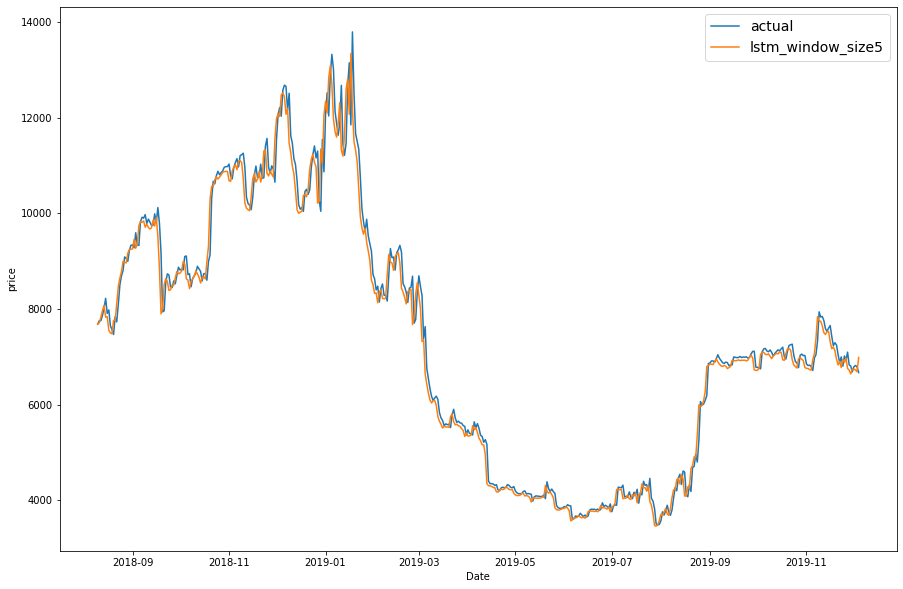

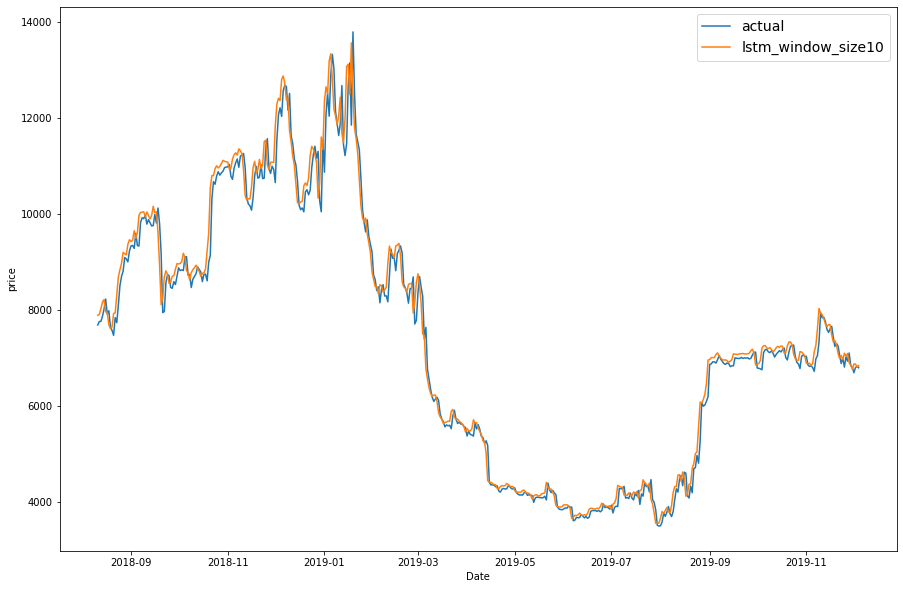

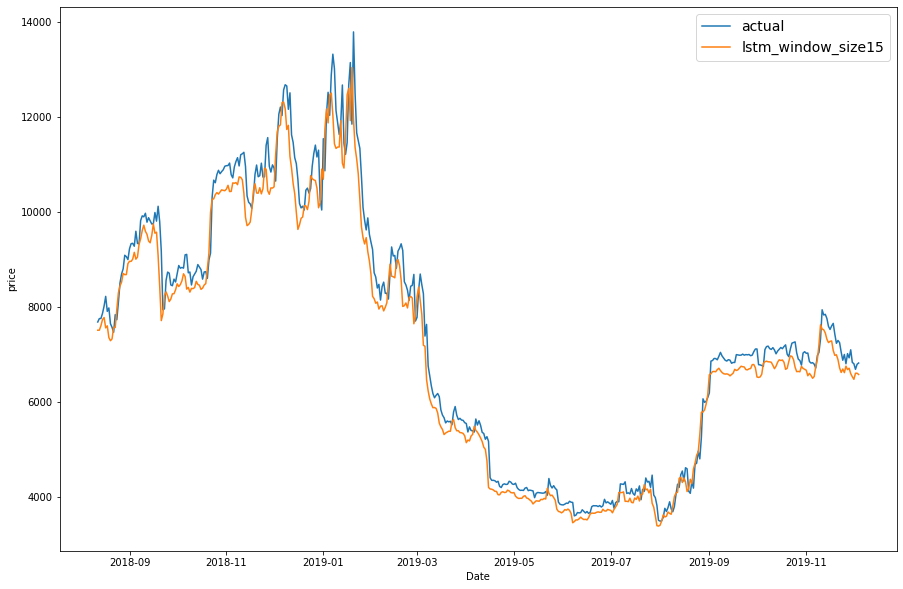

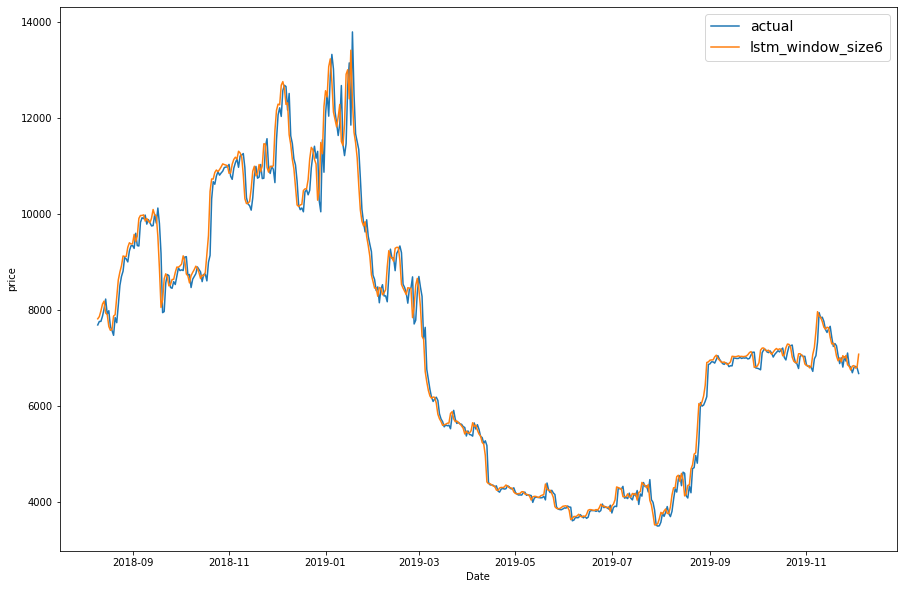

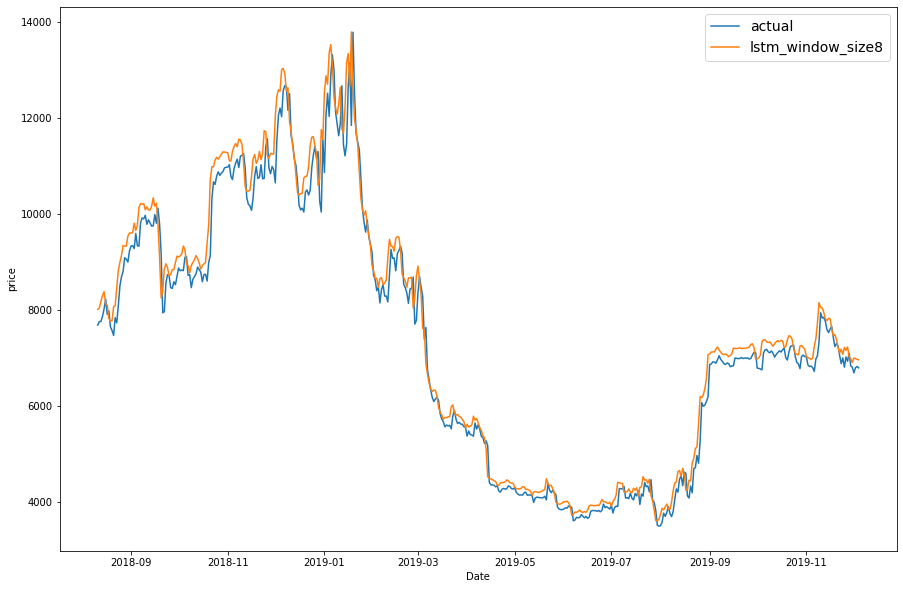

In [41]:
lstm_window_5 = experiment_with_window(5)
lstm_window_10 = experiment_with_window(10)
lstm_window_15 = experiment_with_window(15)
lstm_window_6 = experiment_with_window(6)
lstm_window_8 = experiment_with_window(8)

In [42]:
window_comparison_dict = {'window_size_7': lstm_256[1], 'window_size_5': lstm_window_5[1], 'window_size_10': lstm_window_10[1], 'window_size_15': lstm_window_15[1]}
window_df = pd.DataFrame.from_dict(window_comparison_dict)
window_df

,window_size_7,window_size_5,window_size_10,window_size_15
mae,183.660233,197.845917,208.863876,336.617981
mse,95899.945312,99984.171875,108944.789062,186244.968750
rmse,309.677155,316.202728,330.067841,431.561096
mape,2.352984,2.563688,2.725558,4.490355


In [43]:
window_comparison_dict['window_size_6'] = lstm_window_6[1]
window_comparison_dict['window_size_8'] = lstm_window_8[1]
window_df = pd.DataFrame.from_dict(window_comparison_dict)
window_df

,window_size_7,window_size_5,window_size_10,window_size_15,window_size_6,window_size_8
mae,183.660233,197.845917,208.863876,336.617981,191.115601,284.295654
mse,95899.945312,99984.171875,108944.789062,186244.968750,100254.226562,152836.281250
rmse,309.677155,316.202728,330.067841,431.561096,316.629486,390.942810
mape,2.352984,2.563688,2.725558,4.490355,2.468314,3.824768


A window size of 7 seems to be the ideal configuration for this model. 

## Forecasting using Linear model

Since the problem has been boiled down to that of linear regression, we can attempt to use a feedforward neural network to peform the predictions. 

In [45]:
# First prepare the data with the default window_size
train_windows, train_labels, validation_windows, validation_labels, test_windows, test_labels = prepare_data(WINDOW_SIZE)

In [46]:
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.Dense(256)(x)
output = layers.Dense(HORIZON)(x)
model = tf.keras.Model(inputs=inputs, outputs=output, name=f"Linear_model_1")
model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
model.fit(train_windows, train_labels, epochs=100, batch_size=128, verbose=0, validation_data=(validation_windows, validation_labels))
predictions = make_preds(model, test_windows)

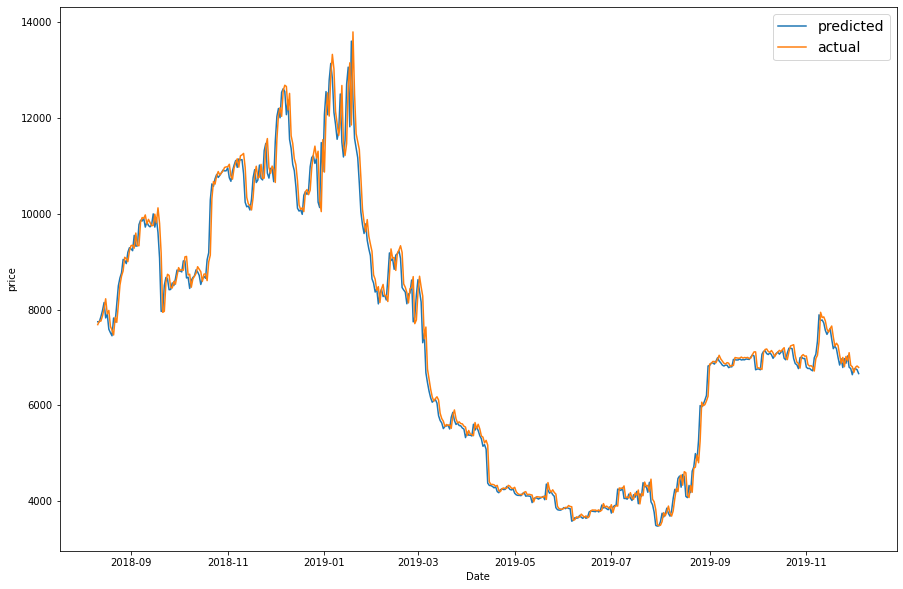

In [47]:
plt.figure(figsize=(15, 10))
plt.plot(data.index[:len(predictions)].to_numpy(), predictions, label='predicted')
plt.plot(data.index[:len(predictions)].to_numpy(), tf.squeeze(test_labels), label='actual')
plt.xlabel('Date')
plt.ylabel('price')
plt.legend(fontsize=14)
plt.show()

It seems like the predictions from a linear model are also close to the actual values. Now lets quantify the performance and compare the numbers. 

In [48]:
evaluate_performance(tf.squeeze(test_labels), predictions)

{'mae': 187.16356, 'mape': 2.4131303, 'mse': 95272.82, 'rmse': 308.66296}

In [49]:
lstm_256[1]

{'mae': 183.66023, 'mape': 2.3529844, 'mse': 95899.945, 'rmse': 309.67715}

This shows that a normal linear model has a similar performance to our lstm model `units=256, batch_size=128, window_size=7`

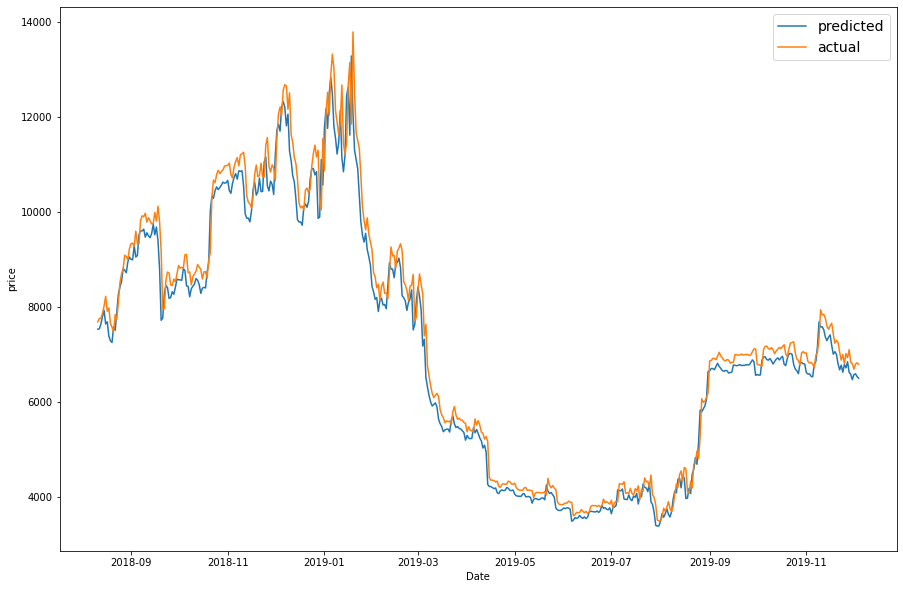

{'mae': 292.65457, 'mape': 3.8898852, 'mse': 152599.6, 'rmse': 390.63998}

In [50]:
# adding a dropout layer in between to see if performance increases. 
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(HORIZON)(x)
model = tf.keras.Model(inputs=inputs, outputs=output, name=f"Linear_model_2")
model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
model.fit(train_windows, train_labels, epochs=100, batch_size=128, verbose=0, validation_data=(validation_windows, validation_labels))
predictions = make_preds(model, test_windows)

plt.figure(figsize=(15, 10))
plt.plot(data.index[:len(predictions)].to_numpy(), predictions, label='predicted')
plt.plot(data.index[:len(predictions)].to_numpy(), tf.squeeze(test_labels), label='actual')
plt.xlabel('Date')
plt.ylabel('price')
plt.legend(fontsize=14)
plt.show()

evaluate_performance(tf.squeeze(test_labels), predictions)

## Forecasting using traditional LSTM approach

Here we revisit the LSTM by considering the input as a single timeseries of length `window_size` of a single feature. 

basically instead of shaping the input as `(None, 1, 7)` we will try if considering the input as `(None, 7, 1)` and passing that to an LSTM results in any improvements in the performance of the LSTM. 

In [51]:
# The ususal flow of constructing the model 
# Print statements explain what I mean to say about the shape of the data
# Setting axis=2 will result in the desired shape
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=2))(inputs)
print(x.shape)
x = layers.LSTM(128, activation="relu")(x)
print(x.shape)

(None, 7, 1)
(None, 128)


In [52]:
def setup_lstm(units=256, batch_size=128):
  inputs = layers.Input(shape=(WINDOW_SIZE))
  x = layers.Lambda(lambda x: tf.expand_dims(x, axis=2))(inputs)
  x = layers.LSTM(units, activation="relu")(x)
  output = layers.Dense(HORIZON)(x)
  model = tf.keras.Model(inputs=inputs, outputs=output, name=f"lstm_{units}")
  model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
  # training the model
  model.fit(train_windows, train_labels, epochs=100, batch_size=batch_size,  verbose=0, validation_data=(validation_windows, validation_labels))
  predictions = make_preds(model, test_windows)
  return predictions, evaluate_performance(tf.squeeze(test_labels), predictions)

In [53]:
lstm_256_2 = setup_lstm()

In [54]:
lstm_256_2[1]

{'mae': 286.3552, 'mape': 3.7437673, 'mse': 166687.25, 'rmse': 408.2735}

In [55]:
lstm_256[1]

{'mae': 183.66023, 'mape': 2.3529844, 'mse': 95899.945, 'rmse': 309.67715}

In [56]:
lstm_128_2 = setup_lstm(units=128)
lstm_128_2[1]

{'mae': 271.71704, 'mape': 3.555902, 'mse': 169681.1, 'rmse': 411.92365}

In [57]:
lstm_128_perf

{'mae': 187.3227, 'mape': 2.4016788, 'mse': 99032.5, 'rmse': 314.6943}

## Conclusion

In this notebook we took the apporach of considering forecasting as a linear regression problem. The models trained using this approach were able to predict values that are close to the actual values. 